<a href="https://colab.research.google.com/github/rk2026/GEOG-510/blob/main/veryRough_MT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import os
from google.colab import drive
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from itertools import product
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_folder = os.path.join('drive', 'My Drive', 'MTanalysis')

In [10]:
# Read the shapefile
cfouter_shp = gpd.read_file(os.path.join(data_folder, 'cfouter.shp'))

# Read the CSV file
treeloc_csv = pd.read_csv(os.path.join(data_folder, 'TreeLoc.csv'))

In [11]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/MTanalysis/TreeLoc.csv")

# Create a GeoDataFrame with the X and Y columns as geometry
geometry = gpd.points_from_xy(df["X"], df["Y"])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to UTM zone 32645
gdf.crs = "EPSG:32645"

Create fishnet and findout the centroid of the fishnet polygon

(3001605.0, 3002595.0)

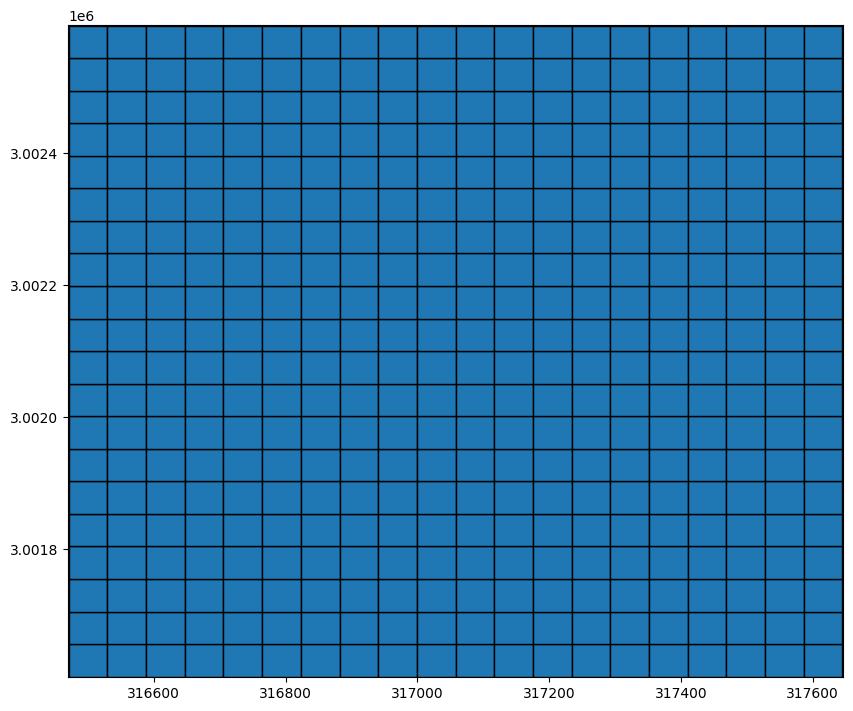

In [12]:
# Define the bounding box coordinates
min_x, min_y = gdf['X'].min(), gdf['Y'].min()
max_x, max_y = gdf['X'].max(), gdf['Y'].max()

# Define the number of rows and columns
rows = 20
cols = 20

# Calculate the width and height of each grid cell
width = (max_x - min_x) / cols
height = (max_y - min_y) / rows

# Generate the grid of polygons
polygons = []
for i, j in product(range(rows), range(cols)):
    xmin = min_x + i * width
    xmax = min_x + (i + 1) * width
    ymin = min_y + j * height
    ymax = min_y + (j + 1) * height
    polygon = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
    polygons.append(polygon)

# Create a GeoDataFrame from the polygons
grid = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:32645')

# Plot the grid
ax = grid.plot(edgecolor='black', figsize=(10, 10))
ax.set_xlim(min_x - 1, max_x + 1)
ax.set_ylim(min_y - 1, max_y + 1)

In [13]:
centroid = grid.geometry.centroid
centroid

0      POINT (316500.350 3001630.700)
1      POINT (316500.350 3001680.100)
2      POINT (316500.350 3001729.500)
3      POINT (316500.350 3001778.900)
4      POINT (316500.350 3001828.300)
                    ...              
395    POINT (317615.650 3002371.700)
396    POINT (317615.650 3002421.100)
397    POINT (317615.650 3002470.500)
398    POINT (317615.650 3002519.900)
399    POINT (317615.650 3002569.300)
Length: 400, dtype: geometry

The centroid is in geoseries format. We need to convert it in geopandas dataframe format.

<Axes: >

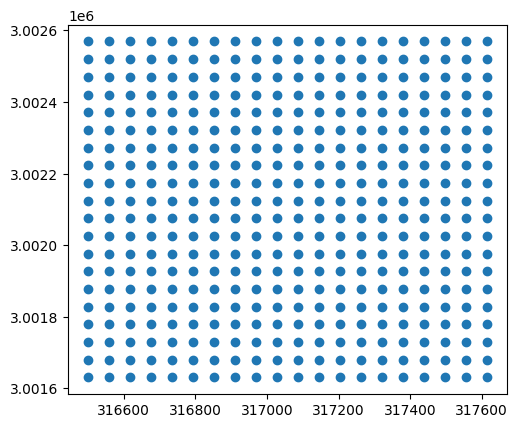

In [14]:
#convert geoseris to geodataframe
data = {'geometry': centroid}
# Create a GeoDataFrame from the dictionary
centroid_gdf = gpd.GeoDataFrame(data)
centroid_gdf.sindex
centroid_gdf.plot()

create spatial index of the dataframe

Spatial join based on closest.

In [15]:
joined = gpd.sjoin_nearest(centroid_gdf,gdf, how="right", distance_col="distance")

Spatial join with geodataframe df1 and df2 based on nearest.

Export shape file to drive

In [16]:
#joined.to_file("/content/drive/MyDrive/MTanalysis/joined.shp")

In [17]:
#joined.to_file("/content/drive/MyDrive/MTanalysis/joined.shp")

In [18]:
#gdf.to_file("/content/drive/MyDrive/MTanalysis/gdf.shp")

In [19]:
#centroid_gdf.to_file("/content/drive/MyDrive/MTanalysis/centroid_gdf.shp")

In [20]:
Joined_sorted = joined.sort_values(by=['index_left', 'class'], ascending=True)

In [21]:
Joined_sorted

,index_left,TreeID,spp,sspp,X,Y,dbh_cm,ht_m,class,geometry,distance
422,3,427,Sissoo,Dalbergia sissoo,316527,3001775,89,30,1,POINT (316527.000 3001775.000),26.933854
13463,3,13468,Khayar,Achacia catechu,316524,3001801,67,17,1,POINT (316524.000 3001801.000),32.368696
19248,3,19253,Sal,Shorea robusta,316529,3001779,39,21,1,POINT (316529.000 3001779.000),28.650175
22304,3,22309,Sal,Shorea robusta,316529,3001801,96,17,3,POINT (316529.000 3001801.000),36.183318
23599,3,23604,Khayar,Achacia catechu,316528,3001760,81,16,4,POINT (316528.000 3001760.000),33.492275
...,...,...,...,...,...,...,...,...,...,...,...
26961,388,26966,Asna,Termenelia Chebula,317594,3002013,34,28,3,POINT (317594.000 3002013.000),25.201835
3383,388,3388,Khayar,Achacia catechu,317597,3002002,87,23,4,POINT (317597.000 3002002.000),30.315549
3741,388,3746,Jamun,Syzezium cumuni,317589,3002007,62,19,4,POINT (317589.000 3002007.000),32.671586
10515,388,10520,Barro,Termenelia belarica,317589,3002025,42,17,4,POINT (317589.000 3002025.000),26.665193


:# Group the GeoDataFrame by the 'right_index' column

In [22]:
grouped_gdf = Joined_sorted.groupby('index_left')

In [23]:
first_unique_rows = grouped_gdf.head(1)

In [24]:
mt=first_unique_rows.copy()

In [25]:
mt

,index_left,TreeID,spp,sspp,X,Y,dbh_cm,ht_m,class,geometry,distance
422,3,427,Sissoo,Dalbergia sissoo,316527,3001775,89,30,1,POINT (316527.000 3001775.000),26.933854
9924,4,9929,Amala,Phylenthus emblica,316529,3001820,55,27,1,POINT (316529.000 3001820.000),29.828049
6632,5,6637,Sal,Shorea robusta,316523,3001901,94,25,1,POINT (316523.000 3001901.000),32.494807
645,6,650,Jamun,Syzezium cumuni,316515,3001928,51,23,1,POINT (316515.000 3001928.000),14.677619
1551,7,1556,Khayar,Achacia catechu,316513,3001969,59,19,1,POINT (316513.000 3001969.000),14.706206
...,...,...,...,...,...,...,...,...,...,...,...
6555,384,6560,Barro,Termenelia belarica,317633,3001840,59,23,1,POINT (317633.000 3001840.000),20.926359
5784,385,5789,Sal,Shorea robusta,317589,3001889,63,21,1,POINT (317589.000 3001889.000),28.946718
551,386,556,Khayar,Achacia catechu,317599,3001914,104,18,1,POINT (317599.000 3001914.000),21.185667
1912,387,1917,Sal,Shorea robusta,317590,3001963,97,22,1,POINT (317590.000 3001963.000),28.985729


In [32]:
# Create a copy of Joined_sorted
df_with_remarks = Joined_sorted.copy()

# Add a new column named 'Remarks'
df_with_remarks['Remarks'] = ''

# Find the indices of TreeIDs that are in the 'mt' variable
mt_indices = df_with_remarks.index[df_with_remarks['TreeID'].isin(mt['TreeID'])]

# Update the 'Remarks' column for those indices with 'mt'
df_with_remarks.loc[mt_indices, 'Remarks'] = 'mt'

# Print the updated DataFrame
df_with_remarks

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


,index_left,TreeID,spp,sspp,X,Y,dbh_cm,ht_m,class,geometry,distance,Remarks
422,3,427,Sissoo,Dalbergia sissoo,316527,3001775,89,30,1,POINT (316527.000 3001775.000),26.933854,mt
13463,3,13468,Khayar,Achacia catechu,316524,3001801,67,17,1,POINT (316524.000 3001801.000),32.368696,
19248,3,19253,Sal,Shorea robusta,316529,3001779,39,21,1,POINT (316529.000 3001779.000),28.650175,
22304,3,22309,Sal,Shorea robusta,316529,3001801,96,17,3,POINT (316529.000 3001801.000),36.183318,
23599,3,23604,Khayar,Achacia catechu,316528,3001760,81,16,4,POINT (316528.000 3001760.000),33.492275,
...,...,...,...,...,...,...,...,...,...,...,...,...
26961,388,26966,Asna,Termenelia Chebula,317594,3002013,34,28,3,POINT (317594.000 3002013.000),25.201835,
3383,388,3388,Khayar,Achacia catechu,317597,3002002,87,23,4,POINT (317597.000 3002002.000),30.315549,
3741,388,3746,Jamun,Syzezium cumuni,317589,3002007,62,19,4,POINT (317589.000 3002007.000),32.671586,
10515,388,10520,Barro,Termenelia belarica,317589,3002025,42,17,4,POINT (317589.000 3002025.000),26.665193,


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [27]:
Joined_sorted.sindex
mt.sindex

In [28]:
intersection['status'] = 'MT'

NameError: name 'intersection' is not defined

In [ ]:
intersection = Joined_sorted[Joined_sorted.intersection(mt.unary_union)]

In [ ]:
intersection